<img src='https://www.icos-cp.eu/sites/default/files/2017-11/ICOS_CP_logo.png' width=400 align=right>

# ICOS Carbon Portal Python Library
## Example: STILT: footprints

This example shows how to load footprints, aggregate the data and create a map.

## Documentation
Full documentation for the library on the [project page](https://icos-carbon-portal.github.io/pylib/), how to install and wheel on [pypi.org](https://pypi.org/project/icoscp/"), source is available on [github](https://github.com/ICOS-Carbon-Portal/pylib)

## Import libraries

In [1]:
from icoscp.stilt import station
import numpy as np
import folium
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

## Create STILT station object
Remember, that station.get() returns a LIST of stilt stations objects, if more than one is found, otherwise it will be directly the STILT object

In [2]:
st = station.get(id='KIT030')

  0%|          | 0/170 [00:00<?, ?it/s]

## Load footprints
The .get_fp function returns by default an xarray object

In [3]:
start = '2018-01-01'
end = '2018-01-31'

stilt_fp = st.get_fp(start, end)

#View fp xarray:
stilt_fp

<xarray.Dataset>
Dimensions:  (lat: 480, lon: 400, time: 241)
Coordinates:
  * lon      (lon) float64 -14.94 -14.81 -14.69 -14.56 ... 34.69 34.81 34.94
  * lat      (lat) float64 33.04 33.12 33.21 33.29 ... 72.71 72.79 72.87 72.96
  * time     (time) datetime64[ns] 2018-01-01 2018-01-01T03:00:00 ... 2018-01-31
Data variables:
    foot     (time, lat, lon) float64 dask.array<chunksize=(1, 480, 400), meta=np.ndarray>
Attributes:
    backtime:     240 hours
    description:  aggregated STILT footprints on lon/lat/time grid, aggregate...

## Extract the boundaries for the image

In [4]:
bounds = [[stilt_fp.coords['lat'].values.min(), stilt_fp.coords['lon'].values.min()],[stilt_fp.coords['lat'].values.max(), stilt_fp.coords['lon'].values.max()]]
bounds

[[33.041666666666664, -14.9375], [72.95833333333337, 34.9375]]

## Aggregate the footprints
 - Extract the values
 - Reshape for folium
 - Normalize to 0-1

In [5]:
image = stilt_fp.foot.mean('time').values 
image = np.nan_to_num(image, nan=0.0)     # make sure no nan values are in the image
image = image / np.nanmax(image)          # normalize values to range 0 to 1
                                          # zero will be transparent in folium
image = np.flip(image)                    # reshape the image to conform for folium orientation
image = np.fliplr(image)

## Quick and dirty plot

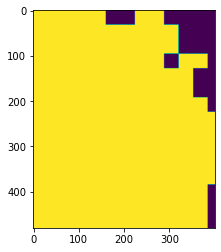

In [6]:
plt.imshow(image>0)

## Create a folium map

In [7]:
station_location = [st.lat, st.lon]

#create the map a
myMap = folium.Map(location=station_location, zoom_start=6)
myMap.control_scale = True
folium.TileLayer('cartodbpositron').add_to(myMap)
folium.TileLayer('cartodbdark_matter').add_to(myMap)

# add the station with marker
folium.Marker([st.lat, st.lon], popup=st.name).add_to(myMap)

# add bounding box to see STILT domain
bbox = [[33, -14],[72, 33] ,[33,34] , [72, -14]]
folium.Rectangle(bbox).add_to(myMap)

## Create a raster layer from footprint and overlay to map
https://python-visualization.github.io/folium/modules.html#module-folium.raster_layers <br>
bounds (list) – Image bounds on the map in the form [[lat_min, lon_min], [lat_max, lon_max]]

In [8]:
cmap = cm.viridis
b = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
norm = cm.colors.BoundaryNorm(b, cmap.N, extend='none')

In [9]:
folium.raster_layers.ImageOverlay(
    image=image,    
    bounds=bounds,   
    #colormap=cmap,
    colormap=lambda x: (1,0,0,x),
    #colormap=lambda x: (1, 0, 0, x),
    mercator_project = True,
    pixelated = False, 
    name=st.id, 
).add_to(myMap)


In [10]:
folium.LayerControl().add_to(myMap)
myMap